In [2]:
%%capture
!git clone https://github.com/matiasdperez/MEC_tesis.git

In [3]:
import os
os.chdir('MEC_tesis/')

# Random Walk

En esta notebook se presenta el caso base que seteará la metodología para los escenarios restantes. En la misma, se simularán 2 tipos de random walk (o camino aleatorio) gaussiano, a saber:
* Vanilla RW: $y_t = y_{t-1} + \epsilon_{t}, \epsilon_{t}~N(0,1)$
* RW con drift y trend = $y_t = α + βt + y_{t-1} + \epsilon_{t}, \epsilon_{t}~N(0,1)$

En cada uno de ellos, se divide la serie temporal simulada en train (el cual será nuevamente subdividido en train y validation) y test. Es en este subconjunto en donde se evalúa y compara la capacidad predictiva de los 5 modelos propuestos, los cuales han sido entrenados (y *cross-validados*) utilizando el conjunto de entrenamiento. Los 5 modelos a comparados son:

* ARIMA
* ETS (Error-Trend-Seasonal Model)
* Stacked LSTM
* Stacked LSTM con Peepholes
* Encoder-Decoder LSTM

En una segunda instancia, se remueve el conjunto de test original y se lo reemplaza por uno en donde se haya producido un cambio de régimen: cada modelo deberá *forecastear* una variable que sigue un DGP distinto al que se usó para su entrenamiento. De esta manera, se evaluará la robustez de las predicciones ante cambios en los parámetros que dictan el DGP.

-------
_______

In [4]:
%load_ext autoreload
%autoreload 2

## 1) Setup

In [5]:
%%capture
! pip install dieboldmariano pmdarima keras-tuner tensorflow-addons

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import warnings
import tqdm as tqdm
import random
from sklearn.preprocessing import StandardScaler
from dieboldmariano import dm_test

pd.set_option('max_colwidth', 400)
warnings.filterwarnings("ignore")

np.random.seed(42)

from utils.simulators import RandomWalk
from utils.statistical_models import *
from utils.NN_models import *

## 2) Simulación

Se instancian 2 objetos de la clase RandomWalk con las siguientes configuraciones:

* vanilla_rw: $y_t = y_{t-1} + \epsilon_{t}, \epsilon_{t} \sim N(0,1)$
* rw_drift_trend = $y_t = 0.01 + 0.0002t + y_{t-1} + \epsilon_{t}, \epsilon_{t}\sim N(0,1)$


 Se simulan 1,000 timesteps bajo las especificaciones que proceden y tomando como valor inicial 0:

In [7]:
n_steps = 1000
random_seed = 42

In [8]:
vanilla_rw = RandomWalk(n_steps=n_steps, drift=0, trend=0, random_seed=random_seed)
vanilla_rw.simulate()

rw_drift_trend = RandomWalk(n_steps=n_steps, drift=0.01, trend=0.0002, random_seed=random_seed)
rw_drift_trend.simulate()

De las 1,000 observaciones simuladas, las primeras 750 constituyen el dataset de entrenamiento y las segundas 250, el de test.

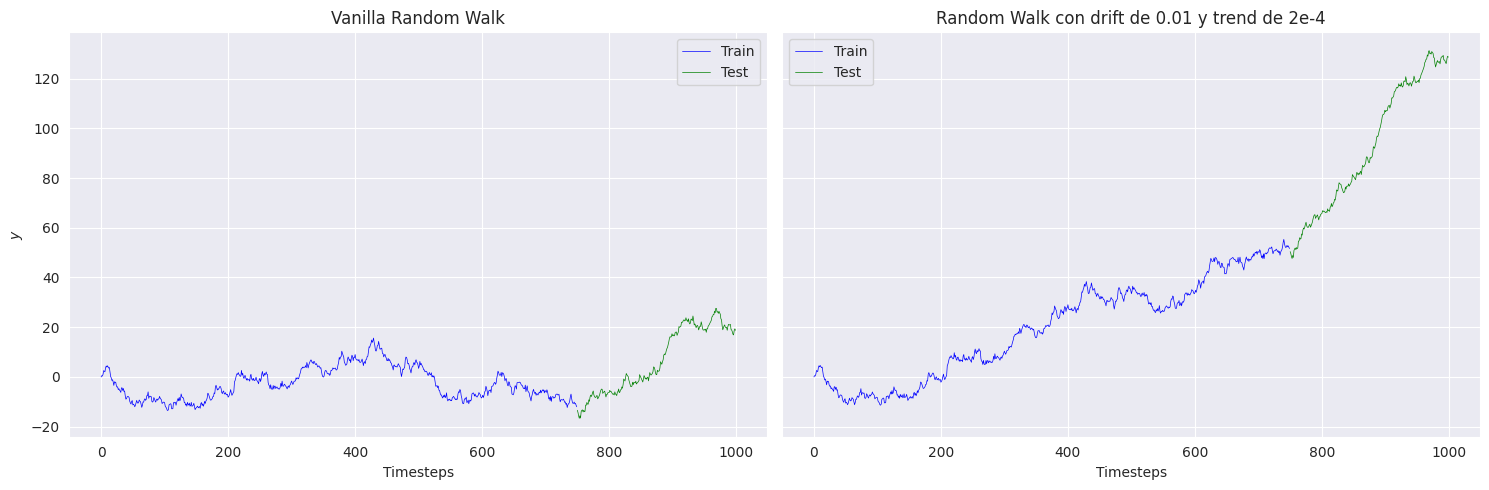

In [9]:
split_index = int(len(vanilla_rw.y) * 0.75)

fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

sns.lineplot(x=range(split_index), y=vanilla_rw.y[:split_index], ax=axs[0], lw=0.5, color='blue', label='Train')
sns.lineplot(x=range(split_index, len(vanilla_rw.y)), y=vanilla_rw.y[split_index:], ax=axs[0], lw=0.5, color='green', label='Test')
axs[0].set_title("Vanilla Random Walk")
axs[0].set_xlabel("Timesteps")
axs[0].set_ylabel("$y$")

sns.lineplot(x=range(split_index), y=rw_drift_trend.y[:split_index], ax=axs[1], lw=0.5, color='blue', label='Train')
sns.lineplot(x=range(split_index, len(rw_drift_trend.y)), y=rw_drift_trend.y[split_index:], ax=axs[1], lw=0.5, color='green', label='Test')
axs[1].set_title("Random Walk con drift de 0.01 y trend de 2e-4")
axs[1].set_xlabel("Timesteps")

plt.legend(loc='upper left')
plt.tight_layout();


Solo a modo de sanity check, se grafican las funciones de autocorrelación y autocorrelación parcial para cada proceso y se observa claramente que se comportan como se esperaría en caso de random walks: los rezagos de las ACF son estadísticamente significativos para cualquier lag, mientras que solo el primer rezago es estadísticamente en la PACF. En otras palabras, este proceso presenta una raíz unitaria e $y_t$ *solo* depende estadísticamente de su valor anterior $y_{t-1}$.

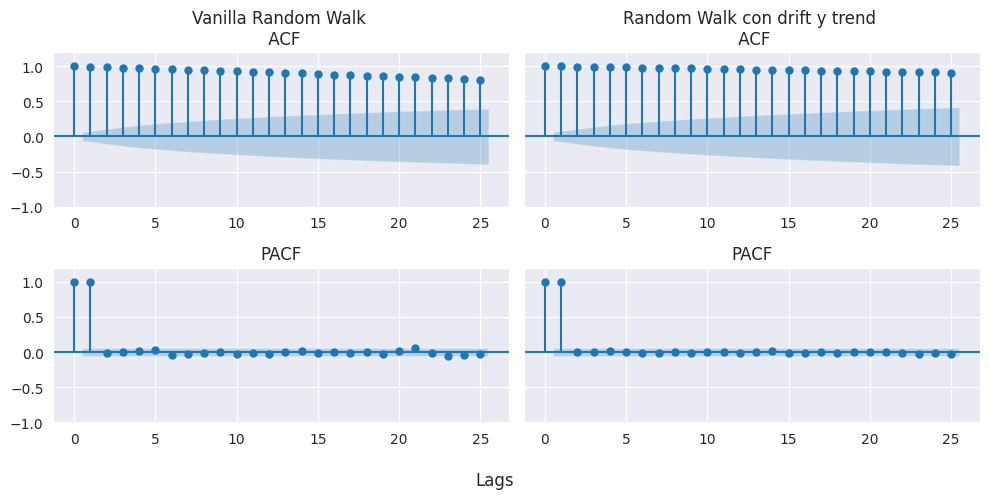

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharey=True)

plot_acf(vanilla_rw.y, lags=25, ax=axs[0,0])
plot_pacf(vanilla_rw.y, lags=25, ax=axs[1,0])
axs[0,0].set_title("Vanilla Random Walk \n ACF")
axs[0,0].set_ylim([-1, 1.2])
axs[1,0].set_title("PACF")

plot_acf(rw_drift_trend.y, lags=25, ax=axs[0,1])
plot_pacf(rw_drift_trend.y, lags=25, ax=axs[1,1])
axs[0,1].set_title("Random Walk con drift y trend \n ACF")
axs[0,1].set_ylim([-1, 1.2])
axs[1,1].set_title("PACF")

fig.supxlabel('Lags')
plt.tight_layout()
plt.show()

A continuación se realiza el split en train-test para cada uno de los DGP simulados. Se toman el primer 75% de las observaciones para train (750 observaciones) y el restante 25% para test (250 observaciones).

In [11]:
vanilla_y_train, vanilla_y_test = vanilla_rw.y[:split_index], vanilla_rw.y[split_index:]
drift_trend_y_train, drift_trend_y_test = rw_drift_trend.y[:split_index], rw_drift_trend.y[split_index:]

## 3) Cross-validation de hiperparámetros

En esta fase del workflow de trabajo, se utiliza el conjunto de entrenamiento y validación para buscar el set de hiperparámetros que mejor ajusta la forma funcional del modelo al problema concreto (i.e, aquel modelo que minimiza el error cuadrático medio sobre el conjunto de validación). Los espacios de hiperparámetros definidos para cada modelo son los siguientes:

1) <ins> Modelo ARIMA </ins>: se buscarán de manera automática la tupla (p,d,q), esto es, el orden del término autorregresivo AR, el orden de integración y el órden del término de medias móviles MA dentro de un espacio de hiperparámetros dado por el producto cartesiano especificado por el usuario. Por ejemplo: {0,1,2,3}x{0,1,2}x{0,1,2,3}.

Para el modelo ARIMA, se utilizan 2 técnicas de crossvalidation:
  * *Sliding window*
  * *Rolling window*

2) <ins> Modelo ETS </ins>: en el caso del modelo ETS, se buscarán de manera automática sobre un espacio de hiperparámetros que definen la forma funcional de las ecuaciones que rigen el modelo. El mismo se define como el producto cartesiano de los siguientes conjuntos:

    * error_type = {aditivo, multiplicativo}
    * trend_type = {sin_tendencia, aditiva, multiplicativa}
    * dampend_trend = {Verdado, Falso}
    * seasonal_component = {}

Al igual que para el caso del modelo ARIMA, se utilizan 2 técnicas de crossvalidation:
  * *Sliding window*
  * *Rolling window*

3) <ins> Stacked LSTM </ins>: para el caso de las redes neuronales, se define una arquitectura general dado por el tipo de unidades o neuronas (en este caso, vanilla LSTM) y un espacio de hiperprámetros "grande", el cual no es explorado de manera exhaustiva sino que se escogen una serie de configuraciones de manera aleatoria y se recupera aquella configuración que minimiza la función de pérdida sobre el conjunto de validación (partición del conjunto de entrenamiento original). Una vez más, el espacio de hiperparámetros se construye como el cartesiano de los siguientes conjuntos:

    * Función de activación = {'relu', 'tanh', 'sigmoid', 'elu'} --> función de activación aplicadas a la cell state y al estado oculto de la red.
    * Unidades en la primera capa recurrente = {16, 32, 64, 128}
    * Incluir segunda capa LSTM = {True, False}
    * Unidades en la segunda capa recurrente (en caso de existir) = {16, 32, 64, 128}
    * Unidades en la capa densa = {16, 32, 64, 128} --> número de neuronas en la capa densa que transforma la salida vectorial de la red LSTM en el valor escalar a predecir.
    * Learning Rate = {1e-2, 1e-3, 1e-4} --> learning_rate utilizado por el optimizador en la búsqueda de los parámetros del modelo.
    * Optimizador = {'adam', 'sgd', 'rmsprop'}
    * Dropout rate = {0, 0.1, 0.2, 0.3, 0.4, 0.5} --> tasa de dropout, utilizada para eliminar conexiones entre neuronas de manera aleatoria durante la fase de entrenamientod de la red y así evitar overfitting
    * Inicializadores = {'random_normal','glorot_uniform', 'he_normal'} --> distribuciones de las que se samplean los valores iniciales de los pesos y biases de la red, y le da naturaleza estocástica al entrenamiento de la NN.
    * Coeficiente L2 = {0, 0.1, 0.2, 0.3, 0.4, 0.5} --> penalización utilizada para evitar que los pesos de la red "crezcan" demasiado y overfitteen la red (aka. weight decay).

4) <ins> LSTM con Peepholes </ins>: mismo espacio de búsqueda de hiperparámetros que el modelo *Stacked LSTM*

5) <ins> Encoder-Decoder LSTM </ins>: la única diferencia en el espacio de hiperparámetros frente a las otras arquitecturas es que en este modelo, en caso de existir una segunda capa oculta, se la fuerza a que tenga una dimensión menor al número de unidades de la primera capa oculta para lograr así la forma de "embudo" típico de las redes neuronales encoder-decoder.


### 3.1) ARIMA model

In [12]:
# Definición del espacio de hiperparámetros sobre el cual buscar la mejor configuración del modelo para el problema

AR_order = [0,1,2,3]
MA_order = [0,1,2,3]
I_order = [0,1,2]

# Dado que el espacio de búsqueda de hiperparámetros tiene una cardinalidad muy alta para realizar una búsqueda exhaustiva, se opta en su lugar
# por tomar una muestra de 30 combinaciones de hiperparámetros del espacio de búsqueda.

random.seed(1234)
search_space = random.sample(list(product(AR_order, I_order, MA_order)), 30)

A modo de ejemplo, se procede a cross-validar el modelo con el search_space recien construido y bajo las siguientes especificaciones:
* `h = 1`
* `stride = 25`
* `window_length = 50`
* `evaluation_metric = mean_squared_error`

El número de folds se determina de manera automática en base a la combinación de `h`, `stride` y `window_length`. El algoritmo de optimización elegido es el método de Nelder-Mead ([link](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ARIMA.html)).

In [13]:
arima_vanilla = ArimaModel(vanilla_y_train, vanilla_y_test, **{'with_intercept':False, 'method':'nm'})

In [14]:
arima_vanilla.cross_validate(ARIMA_configs=search_space,
                              h = 1,
                              stride=25,
                              window_length=50,
                              eval_metric='mean_squared_error')

100%|██████████| 30/30 [03:27<00:00,  6.91s/it]


A continuación se muestra el top 10 configuraciones de hiperparámetros, ordenados por la mediana del error cuadrático en cada fold para la estrategia `sliding_window`.

In [15]:
arima_vanilla.cross_validation_df.sort_values('sliding_median_MSE').head(10)

,AR_order,I_order,MA_order,rolling_median_MSE,sliding_median_MSE
17,3,1,2,0.617649,0.417022
19,2,2,2,0.647205,0.472733
1,0,1,3,0.616234,0.477389
18,3,1,1,0.616328,0.502469
21,3,2,1,0.630013,0.510123
16,0,2,1,0.649090,0.525519
15,2,1,1,0.537101,0.528687
14,2,1,2,0.633907,0.539057
0,2,1,0,0.636671,0.559346
22,1,1,0,0.628508,0.564852


In [16]:
print(f"La mejor configuración para la estrategia de sliding window es: {arima_vanilla.best_model('sliding')}")

La mejor configuración para la estrategia de sliding window es: (3, 1, 2)


Se generaliza la búsqueda del 'mejor conjunto' de hiperparámetros (p,d,q) para cada modelo, variando el horizonte de predicción `h` y utilizando distintos valores de `window_length` y un `stride` fijo de 25. En todos los casos se utiliza una estrategia de cross-validation de tipo `sliding_window` (de la interacción con el hiperparámetro `stride` surgirá si los folds se solapan o no) y la métrica a evaluar sobre el conjunto de validación es MSE.

In [17]:
h_list = [1, 7]
strides_list = [25]
window_length_list = [25, 50, 100]

#### 3.1.1) Vanilla RW

In [18]:
vanilla_rw_arima_results = defaultdict(defaultdict)
rw_best_models = defaultdict((lambda: defaultdict(dict))) #En este diccionario se guardará el mejor modelo para cada DGP y combinación de h, stride y window_length

In [19]:
%%time
for h in h_list:
    best_MSE = 9999
    for s, l in list(product(strides_list, window_length_list)):
        print(f'\n Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = ArimaModel(vanilla_y_train, vanilla_y_test, **{'with_intercept':False, 'method':'nm'})
        model.cross_validate(ARIMA_configs=search_space,
                                                       h = h,
                                                       stride=s,
                                                       window_length=l,
                                                       eval_metric='mean_squared_error')
        MSE = model.cross_validation_df.sort_values('sliding_median_MSE').reset_index()['sliding_median_MSE'][0]
        vanilla_rw_arima_results[h][(s, l)] = {
            'best_model': model.best_model('sliding'),
            'best_MSE': MSE
        }
        if MSE < best_MSE:
            best_MSE = MSE
            rw_best_models['vanilla_rw'][h]['arima'] = model


 Cross-validation model with h=1, stride=25, window_length=25: 



100%|██████████| 30/30 [02:45<00:00,  5.51s/it]



 Cross-validation model with h=1, stride=25, window_length=50: 



100%|██████████| 30/30 [03:04<00:00,  6.17s/it]



 Cross-validation model with h=1, stride=25, window_length=100: 



100%|██████████| 30/30 [02:56<00:00,  5.87s/it]



 Cross-validation model with h=7, stride=25, window_length=25: 



100%|██████████| 30/30 [02:46<00:00,  5.54s/it]



 Cross-validation model with h=7, stride=25, window_length=50: 



100%|██████████| 30/30 [02:50<00:00,  5.68s/it]



 Cross-validation model with h=7, stride=25, window_length=100: 



100%|██████████| 30/30 [02:57<00:00,  5.92s/it]

CPU times: user 15min 48s, sys: 12min 44s, total: 28min 32s
Wall time: 17min 20s


En la siguiente tabla, se observan los resultados de cross-validar de manera conjunta window_length y los parámetros del modelo ARIMA dado un hizonte de forecasting `h` y un `stride` de 25 timesteps. Se observa que para `h = 1`, la mejor configuración usa una ventana de tamaño 25 y no incluye componente autorregresivo, solo componentes MA y una integración de orden 1. En cambio, en la medida que se alarga el horizonte de forecasting a `h = 7`, el modelo se tiende a complejizarse al punto de elegir como mejor conjunto de hiperparámetros $p=3$ y $q=3$. En conclusión, se observa que en la medida que el horizonte de forecasting se alarga, es necesario no solo expandir el tamaño de la ventana móvil (`window_length`) sino añadir lags al modelo.

In [20]:
vanilla_rw_arima_cv = pd.DataFrame([(k1, k2[0], k2[1], v['best_model'][0], v['best_model'][1], v['best_model'][2], v['best_MSE'])
                                for k1, v1 in vanilla_rw_arima_results.items()
                                for k2, v in v1.items()],
                                columns=['h', 'stride', 'window_length', 'AR_order', 'I_order', 'MA_order', 'Best_MSE'])
vanilla_rw_arima_cv

,h,stride,window_length,AR_order,I_order,MA_order,Best_MSE
0,1,25,25,0,1,2,0.350879
1,1,25,50,3,1,2,0.417022
2,1,25,100,0,2,1,0.405985
3,7,25,25,3,1,1,1.588253
4,7,25,50,0,1,2,2.209303
5,7,25,100,3,1,3,1.490671


Se repite este mismo procedimiento para el DGP restante: `RW con drift y trend`.

#### 3.1.2) RW con drift y trend

In [21]:
drift_trend_rw_arima_results = defaultdict(defaultdict)

for h in h_list:
    best_MSE = 9999
    for s, l in list(product(strides_list, window_length_list)):
        print(f'\n Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = ArimaModel(drift_trend_y_train, drift_trend_y_test, **{'with_intercept':False, 'method':'nm'})
        model.cross_validate(ARIMA_configs=search_space,
                                                    h = h,
                                                    stride=s,
                                                    window_length=l,
                                                    eval_metric='mean_squared_error')
        MSE = model.cross_validation_df.sort_values('sliding_median_MSE').reset_index()['sliding_median_MSE'][0]
        drift_trend_rw_arima_results[h][(s, l)] = {
            'best_model': model.best_model('sliding'),
            'best_MSE': MSE
        }
        if MSE < best_MSE:
            best_MSE = MSE
            rw_best_models['drift_trend_rw'][h]['arima'] = model


 Cross-validation model with h=1, stride=25, window_length=25: 



100%|██████████| 30/30 [02:41<00:00,  5.39s/it]



 Cross-validation model with h=1, stride=25, window_length=50: 



100%|██████████| 30/30 [02:40<00:00,  5.36s/it]



 Cross-validation model with h=1, stride=25, window_length=100: 



100%|██████████| 30/30 [02:49<00:00,  5.64s/it]



 Cross-validation model with h=7, stride=25, window_length=25: 



100%|██████████| 30/30 [02:37<00:00,  5.26s/it]



 Cross-validation model with h=7, stride=25, window_length=50: 



100%|██████████| 30/30 [02:41<00:00,  5.37s/it]



 Cross-validation model with h=7, stride=25, window_length=100: 



100%|██████████| 30/30 [02:49<00:00,  5.66s/it]


In [54]:
drift_trend_rw_arima_cv = pd.DataFrame([(k1, k2[0], k2[1], v['best_model'][0], v['best_model'][1], v['best_model'][2], v['best_MSE'])
                                for k1, v1 in drift_trend_rw_arima_results.items()
                                for k2, v in v1.items()],
                                columns=['h', 'stride', 'window_length', 'AR_order', 'I_order', 'MA_order', 'Best_MSE'])
drift_trend_rw_arima_cv

,h,stride,window_length,AR_order,I_order,MA_order,Best_MSE
0,1,25,25,3,1,1,0.358034
1,1,25,50,2,1,1,0.490119
2,1,25,100,0,2,1,0.406197
3,7,25,25,3,1,1,1.479761
4,7,25,50,3,1,2,1.566094
5,7,25,100,3,1,3,1.406973


De los dos escenarios planteados, parece desprenderse del proceso de validación cruzada lo siguiente sobre los modelos ARIMA:
* Que a mayor horizonte de pronóstico `h`, mayor el tamaño de la ventana móvil seleccionada para entrenar el modelo (de 25 timesteps a 100).
* A mayor horizonte de pronoóstico, más complejo se vuelve el modelo (incorpora más lags) para adaptarse a los datos.

### 3.2) ETS Model

In [23]:
# Definición del espacio de búsqueda de hiperparámetros para el modelo ETS

config = {
    'error' : ['add','mul'],
    'trend' : ['add','mul', None],
    'damped_trend' : [True, False],
    'seasonal' : [None]
}

# Dado que el espacio de búsqueda tiene baja cardinalidad, a diferencia del modelo ARIMA, se opta por una búsqueda exhaustiva de hiperparámetros

search_space = [dict(zip(config.keys(), x)) for x in product(*config.values())]

In [24]:
ets_vanilla = EtsModel(vanilla_y_train, vanilla_y_test)

In [25]:
ets_vanilla.cross_validate(ETS_configs=search_space,
                              h = 1,
                              stride=25,
                              window_length=50,
                              eval_metric='mean_squared_error')

100%|██████████| 12/12 [00:02<00:00,  4.60it/s]


A continuación se muestra el top configuraciones de hiperparámetros, ordenados por la mediana del error cuadrático en cada fold para la estrategia `sliding_window`.

In [26]:
ets_vanilla.cross_validation_df.sort_values('sliding_median_MSE').head(10)

,index,rolling_median_MSE,sliding_median_MSE
2,"{'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}",0.62843,0.53357
0,"{'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",0.62730,0.56044
1,"{'error': 'add', 'trend': 'add', 'damped_trend': False, 'seasonal': None}",0.64210,0.62260


In [27]:
print(f"La mejor configuración para la estrategia de sliding window es: {ets_vanilla.best_model('sliding')['index']}")

La mejor configuración para la estrategia de sliding window es: {'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}


A continuación, se generaliza la búsqueda del 'mejor conjunto' de hiperparámetros (p,d,q) para cada modelo, variando el horizonte de predicción `h` y utilizando distintos valores de `window_length` y un `stride` fijo de 25. En todos los casos se utiliza una estrategia de cross-validation de tipo `sliding_window` (de la interacción con el hiperparámetro `stride` surgirá si los folds se solapan o no) y la métrica a evaluar sobre el conjunto de validación es MSE.

In [28]:
h_list = [1, 7]
strides_list = [25]
window_length_list = [25, 50, 100]

#### 3.2.1) Vanilla RW

In [29]:
vanilla_rw_ets_results = defaultdict(defaultdict)

for h in h_list:
    best_MSE = 9999
    for s, l in list(product(strides_list, window_length_list)):
        print(f'\n Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = EtsModel(vanilla_y_train, vanilla_y_test)
        model.cross_validate(ETS_configs=search_space,
                            h = h,
                            stride=s,
                            window_length=l,
                            eval_metric='mean_squared_error')
        MSE = model.cross_validation_df.sort_values('sliding_median_MSE').reset_index()['sliding_median_MSE'][0]
        vanilla_rw_ets_results[h][(s, l)] = {
            'best_model': model.best_model('sliding')['index'],
            'best_MSE': MSE
        }
        if MSE < best_MSE:
            best_MSE = MSE
            rw_best_models['vanilla_rw'][h]['ets'] = model


 Cross-validation model with h=1, stride=25, window_length=25: 



100%|██████████| 12/12 [00:02<00:00,  4.14it/s]



 Cross-validation model with h=1, stride=25, window_length=50: 



100%|██████████| 12/12 [00:03<00:00,  3.30it/s]



 Cross-validation model with h=1, stride=25, window_length=100: 



100%|██████████| 12/12 [00:02<00:00,  4.45it/s]



 Cross-validation model with h=7, stride=25, window_length=25: 



100%|██████████| 12/12 [00:02<00:00,  4.08it/s]



 Cross-validation model with h=7, stride=25, window_length=50: 



100%|██████████| 12/12 [00:02<00:00,  4.55it/s]



 Cross-validation model with h=7, stride=25, window_length=100: 



100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


In [55]:
data = []

for key1, value1 in vanilla_rw_ets_results.items():
    for key2, value2 in value1.items():
        row = value2.copy()
        row['h'] = key1
        row['stride'], row['window_length'] = key2
        data.append(row)

columns = ['h', 'stride', 'window_length', 'best_model', 'best_MSE']
vanilla_rw_ets_cv = pd.DataFrame(data, columns=columns)

vanilla_rw_ets_cv

,h,stride,window_length,best_model,best_MSE
0,1,25,25,"{'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",0.68385
1,1,25,50,"{'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}",0.53357
2,1,25,100,"{'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}",0.45065
3,7,25,25,"{'error': 'add', 'trend': 'add', 'damped_trend': False, 'seasonal': None}",1.13849
4,7,25,50,"{'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",1.16243
5,7,25,100,"{'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",1.11864


¿Cómo interpretar estos resultados? Se observa, por ejemplo, que para un `h=1` y un `stride=25`, la combinación de `window_length=100` e hiperparámetros `{'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}` minimiza el error cuadrático medio para el conjunto de validación construido. Esto ocurren en tanto se está *crossvalidando* al mismo tiempo la longitud de la ventana temporal como los hiperparámetros del modelo.

Se observa que para este DGP, la validación cruzada automática de hiperparámetros siempre termina eligiendo como la mejor configuración aquella que tiene `window_length=100` y un error aditivo, variando si incorpora o no tendencia, independientemente del horizonte de forecasting.

Para más información sobre los hiperparámetros del modelo, consultar [aquí](https://www.statsmodels.org/dev/examples/notebooks/generated/ets.html).

#### 3.2.2) RW con drift y tendencia

In [31]:
drift_trend_rw_ets_results = defaultdict(defaultdict)

for h in h_list:
    best_MSE = 9999
    for s, l in list(product(strides_list, window_length_list)):
        print(f'\n Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = EtsModel(drift_trend_y_train, drift_trend_y_test)
        model.cross_validate(ETS_configs=search_space,
                            h = h,
                            stride=s,
                            window_length=l,
                            eval_metric='mean_squared_error')
        MSE = model.cross_validation_df.sort_values('sliding_median_MSE').reset_index()['sliding_median_MSE'][0]
        drift_trend_rw_ets_results[h][(s, l)] = {
            'best_model': model.best_model('sliding')['index'],
            'best_MSE': MSE
        }
        if MSE < best_MSE:
            best_MSE = MSE
            rw_best_models['drift_trend_rw'][h]['ets'] = model


 Cross-validation model with h=1, stride=25, window_length=25: 



100%|██████████| 12/12 [00:05<00:00,  2.00it/s]



 Cross-validation model with h=1, stride=25, window_length=50: 



100%|██████████| 12/12 [00:04<00:00,  2.60it/s]



 Cross-validation model with h=1, stride=25, window_length=100: 



100%|██████████| 12/12 [00:05<00:00,  2.23it/s]



 Cross-validation model with h=7, stride=25, window_length=25: 



100%|██████████| 12/12 [00:05<00:00,  2.27it/s]



 Cross-validation model with h=7, stride=25, window_length=50: 



100%|██████████| 12/12 [00:04<00:00,  2.60it/s]



 Cross-validation model with h=7, stride=25, window_length=100: 



100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


In [32]:
data = []

for key1, value1 in drift_trend_rw_ets_results.items():
    for key2, value2 in value1.items():
        row = value2.copy()
        row['h'] = key1
        row['stride'], row['window_length'] = key2
        data.append(row)

columns = ['h', 'stride', 'window_length', 'best_model', 'best_MSE']
drift_trend_rw_ets_cv = pd.DataFrame(data, columns=columns)

drift_trend_rw_ets_cv

,h,stride,window_length,best_model,best_MSE
0,1,25,25,"{'error': 'add', 'trend': 'add', 'damped_trend': False, 'seasonal': None}",0.68126
1,1,25,50,"{'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",0.58781
2,1,25,100,"{'error': 'add', 'trend': 'add', 'damped_trend': False, 'seasonal': None}",0.45165
3,7,25,25,"{'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",1.19529
4,7,25,50,"{'error': 'add', 'trend': 'add', 'damped_trend': False, 'seasonal': None}",1.25373
5,7,25,100,"{'error': 'add', 'trend': 'add', 'damped_trend': False, 'seasonal': None}",1.13800


Al igual que para el caso vanilla_rw, la cross-validation de los hiperparámetros del modelo parece coincidir que:


*   A mayor horizonte de pronóstico $h$, más larga la ventana móvil con que se entrena el modelo.
*   A mayor horizonte de pronóstico $h$, más complejo se vuelve el modelo (de no incluir a incluir tendencia aditiva).



### 3.3) Stacked LSTM

In [33]:
# El entrenamiento de redes neuronales suele ser más estable si se normalizan los datos de entrada. Por lo tanto, se normalizan los datos de entrenamiento y test de cada DGP simulado.

scaler_vanilla = StandardScaler()

vanilla_y_train_scaled = scaler_vanilla.fit_transform(vanilla_y_train.reshape(-1, 1))
vanilla_y_test_scaled = scaler_vanilla.transform(vanilla_y_test.reshape(-1, 1))

In [34]:
LSTM_model = LSTMnetwork(train=vanilla_y_train_scaled,
                         test=vanilla_y_test_scaled,
                         seq_length=25, h=1, batch_size=64, stride=25)

In [35]:
LSTM_model.cross_validate(DGP='example')

Reloading Tuner from tuner/LSTM/example_LSTM_25_seq_1_h_64_batch_25_stride/tuner0.json


In [36]:
LSTM_model.tuner.get_best_hyperparameters()[0].values

{'activation': 'tanh',
 'recurrent_layer_1': 128,
 'recurrent_layer_2': 64,
 'dense_layer_1': 128,
 'learning_rate': 0.001,
 'optimizer': 'adam',
 'drop_out_rate': 0.1,
 'initializer': 'glorot_uniform',
 'l2_coeff': 0.0,
 'with_second_hidden_layer': True}

### 3.3.1) Vanilla RW

A diferencia de los modelos ARIMA y ETS en donde, dado `h` y fijado el `stride=25`, se *cross-validaban* conjuntamente el `window_length` y los hiperpámetros propios del modelo, en el caso de las NN se le agrega un hiperparámetro adicional: el `batch_size`, es decir, el número de secuencias que son procesadas de manera conjunta para obtener el gradiente y propagarlo hacia atrás en la red.

In [37]:
h_list = [1, 7]
strides_list = [25]
window_length_list = [2, 5, 25, 50, 100]
batch_size = [32, 64, 128]

# Dado el costo computacional de cross-validar una red neuronal, se opta por elegir aleatoriamente 5 combinaciones de
# window_length y batch_size para cross-validar

random.seed(42)
search_space = product(strides_list, random.sample(list(product(window_length_list, batch_size)), 5))
search_space = [[i[0], i[1][0], i[1][1]] for i in search_space]

print('Las cobinaciones de stride, window_length y batch_size a crossvalidar son: {}'.format(search_space))

Las cobinaciones de stride, window_length y batch_size a crossvalidar son: [[25, 50, 64], [25, 2, 64], [25, 2, 32], [25, 50, 128], [25, 5, 64]]


In [38]:
os.chdir('notebooks/simulaciones')

In [39]:
vanilla_rw_stacked_lstm_results = defaultdict(defaultdict)

seed = 42

for h in h_list:
    best_MSE = 9999
    for s, l, b in search_space:
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = LSTMnetwork(train=vanilla_y_train_scaled,
                            test=vanilla_y_test_scaled,
                            seq_length=l,
                            h=h,
                            batch_size=b,
                            stride=s)

        model.cross_validate(DGP = f'vanilla_rw',
                            **{'seed':seed, 'epochs':5})

        MSE = model.tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value('val_loss')

        vanilla_rw_stacked_lstm_results[h][(s, l, b)] = {
            'best_model': model.tuner.get_best_hyperparameters()[0].values,
            'best_MSE': MSE
        }

        if MSE < best_MSE:
            best_MSE = MSE
            rw_best_models['vanilla_rw'][h]['stacked_lstm'] = model

        seed += 1

Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/LSTM/vanilla_rw_LSTM_50_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/LSTM/vanilla_rw_LSTM_2_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/LSTM/vanilla_rw_LSTM_2_seq_1_h_32_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/LSTM/vanilla_rw_LSTM_50_seq_1_h_128_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=5: 

Reloading Tuner from tuner/LSTM/vanilla_rw_LSTM_5_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=50: 

Reloading Tuner from tuner/LSTM/vanilla_rw_LSTM_50_seq_7_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=2: 

Reloading Tuner fr

In [40]:
flattened_data = []
for outer_key, inner_dict in vanilla_rw_stacked_lstm_results.items():
    for config, results in inner_dict.items():
        row = {
            'h': outer_key,
            'config': config,
            **results['best_model'],
            'best_MSE': results['best_MSE']
        }
        flattened_data.append(row)

vanilla_rw_lstm_cv = pd.DataFrame(flattened_data)

vanilla_rw_lstm_cv[['stride', 'length', 'batch_size']] = vanilla_rw_lstm_cv['config'].apply(lambda x: pd.Series(x))
vanilla_rw_lstm_cv = vanilla_rw_lstm_cv.drop(columns=['config'])
column_order = ['h', 'stride', 'length', 'batch_size'] + \
    [col for col in vanilla_rw_lstm_cv.columns if col not in ['h', 'stride', 'length', 'batch_size']]
vanilla_rw_lstm_cv = vanilla_rw_lstm_cv.reindex(columns=column_order).sort_values(['h','best_MSE'], ascending=[True, True])

vanilla_rw_lstm_cv

,h,stride,length,batch_size,activation,recurrent_layer_1,recurrent_layer_2,dense_layer_1,learning_rate,optimizer,drop_out_rate,initializer,l2_coeff,with_second_hidden_layer,best_MSE
3,1,25,50,128,elu,64,16,16,0.0100,rmsprop,0.4,glorot_uniform,0.0,False,0.063081
1,1,25,2,64,relu,16,128,128,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.078287
2,1,25,2,32,tanh,32,16,16,0.0001,rmsprop,0.4,random_normal,0.0,False,0.646544
4,1,25,5,64,relu,16,64,64,0.0001,adam,0.0,random_normal,0.4,False,1.735528
0,1,25,50,64,relu,16,64,64,0.0001,adam,0.0,random_normal,0.4,False,1.746614
9,7,25,5,64,sigmoid,16,32,64,0.0100,rmsprop,0.0,glorot_uniform,0.0,False,0.084992
7,7,25,2,32,elu,64,16,64,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.116737
6,7,25,2,64,relu,16,128,64,0.0010,rmsprop,0.2,he_normal,0.0,True,0.165987
5,7,25,50,64,relu,64,16,128,0.0001,rmsprop,0.3,random_normal,0.0,False,0.606154
8,7,25,50,128,relu,64,16,128,0.0001,rmsprop,0.3,random_normal,0.0,False,0.612270


¿Cómo ha de interpretarse este resultado? Si se toma de ejemplo el caso de $h=1$, la arquitectura que minimiza el MSE sobre el conjunto de validación se compone de:



*   Una única capa recurrente (`with_second_hidden_layer = False`) con 64 neuronas de tipo LSTM + una capa densa de con 16 neuronas.
*   Los pesos de la red son inicializados usando una distribución `glorot_uniform` y no se aplica una penalización L2 o weight_decay.
* Se aplica un drop_out de conexiones durante fase de entrenamiento del 40%.
* La función de activación es de tipo `elu`.
* El optimizador elegido es de tipo `rmsprop` con un learning_rate de 0.01.
* En cuanto al entrenamiento, los hiperparámetros escogidos son un `batch_size = 128` y un `window_length = 50`.



### 3.3.2) RW con drift y tendencia

In [41]:
scaler_drift_trend = StandardScaler()

drift_trend_y_train_scaled = scaler_drift_trend.fit_transform(drift_trend_y_train.reshape(-1, 1))
drift_trend_y_test_scaled = scaler_drift_trend.transform(drift_trend_y_test.reshape(-1, 1))

In [42]:
drift_trend_rw_stacked_lstm_results = defaultdict(defaultdict)

seed = 42

for h in h_list:
    best_MSE = 9999
    for s, l, b in search_space:
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = LSTMnetwork(train=drift_trend_y_train_scaled,
                            test=drift_trend_y_test_scaled,
                            seq_length=l,
                            h=h,
                            batch_size=b,
                            stride=s)

        model.cross_validate(DGP = f'drift_trend_rw',
                            **{'seed':seed, 'epochs':5})

        MSE = model.tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value('val_loss')

        drift_trend_rw_stacked_lstm_results[h][(s, l, b)] = {
            'best_model': model.tuner.get_best_hyperparameters()[0].values,
            'best_MSE': MSE
        }

        if MSE < best_MSE:
            best_MSE = MSE
            rw_best_models['drift_trend_rw'][h]['stacked_lstm'] = model

        seed += 1

Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/LSTM/drift_trend_rw_LSTM_50_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/LSTM/drift_trend_rw_LSTM_2_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/LSTM/drift_trend_rw_LSTM_2_seq_1_h_32_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/LSTM/drift_trend_rw_LSTM_50_seq_1_h_128_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=5: 

Reloading Tuner from tuner/LSTM/drift_trend_rw_LSTM_5_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=50: 

Reloading Tuner from tuner/LSTM/drift_trend_rw_LSTM_50_seq_7_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length

In [43]:
flattened_data = []
for outer_key, inner_dict in drift_trend_rw_stacked_lstm_results.items():
    for config, results in inner_dict.items():
        row = {
            'h': outer_key,
            'config': config,
            **results['best_model'],
            'best_MSE': results['best_MSE']
        }
        flattened_data.append(row)

drift_trend_rw_lstm_cv = pd.DataFrame(flattened_data)

drift_trend_rw_lstm_cv[['stride', 'length', 'batch_size']] = drift_trend_rw_lstm_cv['config'].apply(lambda x: pd.Series(x))
drift_trend_rw_lstm_cv = drift_trend_rw_lstm_cv.drop(columns=['config'])
column_order = ['h', 'stride', 'length', 'batch_size'] + \
    [col for col in drift_trend_rw_lstm_cv.columns if col not in ['h', 'stride', 'length', 'batch_size']]
drift_trend_rw_lstm_cv = drift_trend_rw_lstm_cv.reindex(columns=column_order).sort_values(['h','best_MSE'], ascending=[True, True])

drift_trend_rw_lstm_cv

,h,stride,length,batch_size,activation,recurrent_layer_1,recurrent_layer_2,dense_layer_1,learning_rate,optimizer,drop_out_rate,initializer,l2_coeff,with_second_hidden_layer,best_MSE
3,1,25,50,128,elu,64,16,16,0.0100,rmsprop,0.4,glorot_uniform,0.0,False,0.063385
0,1,25,50,64,elu,64,16,16,0.0100,rmsprop,0.4,glorot_uniform,0.0,False,0.104912
1,1,25,2,64,relu,16,128,128,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.630575
2,1,25,2,32,tanh,32,16,16,0.0001,rmsprop,0.4,random_normal,0.0,False,1.200354
4,1,25,5,64,sigmoid,16,16,32,0.0001,rmsprop,0.2,random_normal,0.1,True,2.102018
7,7,25,2,32,elu,64,16,64,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.240166
5,7,25,50,64,elu,64,16,64,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.316408
6,7,25,2,64,relu,16,128,64,0.0010,rmsprop,0.2,he_normal,0.0,True,0.499643
9,7,25,5,64,sigmoid,16,32,64,0.0100,rmsprop,0.0,glorot_uniform,0.0,False,0.610297
8,7,25,50,128,relu,64,16,128,0.0001,rmsprop,0.3,random_normal,0.0,False,1.417061


### 3.4) Stacked LSTM con Peepholes

#### 3.4.1) Vanilla RW

In [44]:
vanilla_rw_peephole_lstm_results = defaultdict(defaultdict)

seed = 42

for h in h_list:
    best_MSE = 9999
    for s, l, b in search_space:
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = PeepholedLSTMnetwork(train=vanilla_y_train_scaled,
                            test=vanilla_y_test_scaled,
                            seq_length=l,
                            h=h,
                            batch_size=b,
                            stride=s)

        model.cross_validate(DGP = f'vanilla_rw',
                            **{'seed':seed, 'epochs':5})

        MSE = model.tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value('val_loss')

        vanilla_rw_peephole_lstm_results[h][(s, l, b)] = {
            'best_model': model.tuner.get_best_hyperparameters()[0].values,
            'best_MSE': MSE
        }

        if MSE < best_MSE:
            best_MSE = MSE
            rw_best_models['vanilla_rw'][h]['peephole_lstm'] = model

        seed += 1

Cross-validation model with h=1, stride=25, window_length=50: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/vanilla_rw_LSTM_50_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/vanilla_rw_LSTM_2_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/vanilla_rw_LSTM_2_seq_1_h_32_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=50: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/vanilla_rw_LSTM_50_seq_1_h_128_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=5: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/vanilla_rw_LSTM_5_seq_1_h_64_batch_25_stride/tu

In [45]:
flattened_data = []
for outer_key, inner_dict in vanilla_rw_peephole_lstm_results.items():
    for config, results in inner_dict.items():
        row = {
            'h': outer_key,
            'config': config,
            **results['best_model'],
            'best_MSE': results['best_MSE']
        }
        flattened_data.append(row)

vanilla_rw_peephole_lstm_cv = pd.DataFrame(flattened_data)

vanilla_rw_peephole_lstm_cv[['stride', 'length', 'batch_size']] = vanilla_rw_peephole_lstm_cv['config'].apply(lambda x: pd.Series(x))
vanilla_rw_peephole_lstm_cv = vanilla_rw_peephole_lstm_cv.drop(columns=['config'])
column_order = ['h', 'stride', 'length', 'batch_size'] + \
    [col for col in vanilla_rw_peephole_lstm_cv.columns if col not in ['h', 'stride', 'length', 'batch_size']]
vanilla_rw_peephole_lstm_cv = vanilla_rw_peephole_lstm_cv.reindex(columns=column_order).sort_values(['h','best_MSE'], ascending=[True, True])

vanilla_rw_peephole_lstm_cv

,h,stride,length,batch_size,activation,recurrent_layer_1,recurrent_layer_2,dense_layer_1,learning_rate,optimizer,drop_out_rate,initializer,l2_coeff,with_second_hidden_layer,best_MSE
1,1,25,2,64,relu,16,128,128,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.161750
3,1,25,50,128,elu,64,16,16,0.0100,rmsprop,0.4,glorot_uniform,0.0,False,0.579040
2,1,25,2,32,tanh,32,16,16,0.0001,rmsprop,0.4,random_normal,0.0,False,0.651231
0,1,25,50,64,tanh,128,64,128,0.0010,adam,0.1,glorot_uniform,0.0,True,0.683973
4,1,25,5,64,sigmoid,16,16,32,0.0001,rmsprop,0.2,random_normal,0.1,True,1.106971
7,7,25,2,32,elu,64,16,64,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.211544
9,7,25,5,64,sigmoid,16,32,64,0.0100,rmsprop,0.0,glorot_uniform,0.0,False,0.217865
6,7,25,2,64,relu,16,128,64,0.0010,rmsprop,0.2,he_normal,0.0,True,0.431805
8,7,25,50,128,relu,64,16,128,0.0001,rmsprop,0.3,random_normal,0.0,False,0.618306
5,7,25,50,64,elu,128,16,32,0.0010,adam,0.2,he_normal,0.0,True,0.735886


#### 3.4.2) RW con drift y trend

In [46]:
drift_trend_rw_peephole_lstm_results = defaultdict(defaultdict)

seed = 42

for h in h_list:
    best_MSE = 9999
    for s, l, b in search_space:
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = PeepholedLSTMnetwork(train=drift_trend_y_train_scaled,
                            test=drift_trend_y_test_scaled,
                            seq_length=l,
                            h=h,
                            batch_size=b,
                            stride=s)

        model.cross_validate(DGP = f'drift_trend_rw',
                            **{'seed':seed, 'epochs':5})

        MSE = model.tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value('val_loss')

        drift_trend_rw_peephole_lstm_results[h][(s, l, b)] = {
            'best_model': model.tuner.get_best_hyperparameters()[0].values,
            'best_MSE': MSE
        }

        if MSE < best_MSE:
            best_MSE = MSE
            rw_best_models['drift_trend_rw'][h]['peephole_lstm'] = model

        seed += 1

Cross-validation model with h=1, stride=25, window_length=50: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/drift_trend_rw_LSTM_50_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/drift_trend_rw_LSTM_2_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/drift_trend_rw_LSTM_2_seq_1_h_32_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=50: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/drift_trend_rw_LSTM_50_seq_1_h_128_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=5: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/drift_trend_rw_LSTM_5_seq_1_h_6

In [53]:
flattened_data = []
for outer_key, inner_dict in drift_trend_rw_peephole_lstm_results.items():
    for config, results in inner_dict.items():
        row = {
            'h': outer_key,
            'config': config,
            **results['best_model'],
            'best_MSE': results['best_MSE']
        }
        flattened_data.append(row)

drift_trend_rw_peephole_lstm_cv = pd.DataFrame(flattened_data)

drift_trend_rw_peephole_lstm_cv[['stride', 'length', 'batch_size']] = drift_trend_rw_peephole_lstm_cv['config'].apply(lambda x: pd.Series(x))
drift_trend_rw_peephole_lstm_cv = drift_trend_rw_peephole_lstm_cv.drop(columns=['config'])
column_order = ['h', 'stride', 'length', 'batch_size'] + \
    [col for col in drift_trend_rw_peephole_lstm_cv.columns if col not in ['h', 'stride', 'length', 'batch_size']]
drift_trend_rw_peephole_lstm_cv = drift_trend_rw_peephole_lstm_cv.reindex(columns=column_order).sort_values(['h','best_MSE'], ascending=[True, True])

drift_trend_rw_peephole_lstm_cv

,h,stride,length,batch_size,activation,recurrent_layer_1,recurrent_layer_2,dense_layer_1,learning_rate,optimizer,drop_out_rate,initializer,l2_coeff,with_second_hidden_layer,best_MSE
3,1,25,50,128,elu,64,16,16,0.0100,rmsprop,0.4,glorot_uniform,0.0,False,0.182590
0,1,25,50,64,tanh,128,64,128,0.0010,adam,0.1,glorot_uniform,0.0,True,0.277888
1,1,25,2,64,relu,16,128,128,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,1.038997
2,1,25,2,32,tanh,32,16,16,0.0001,rmsprop,0.4,random_normal,0.0,False,1.198726
4,1,25,5,64,sigmoid,16,16,32,0.0001,rmsprop,0.2,random_normal,0.1,True,1.300676
5,7,25,50,64,elu,128,16,32,0.0010,adam,0.2,he_normal,0.0,True,0.251322
7,7,25,2,32,elu,64,16,64,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.381834
9,7,25,5,64,sigmoid,16,32,64,0.0100,rmsprop,0.0,glorot_uniform,0.0,False,0.946821
6,7,25,2,64,relu,16,128,64,0.0010,rmsprop,0.2,he_normal,0.0,True,1.266482
8,7,25,50,128,relu,64,16,128,0.0001,rmsprop,0.3,random_normal,0.0,False,1.439163


### 3.5) Encoder-Decoder LSTM

#### 3.5.1) Vanilla RW

In [48]:
vanilla_rw_s2s_lstm_results = defaultdict(defaultdict)

seed = 42

for h in h_list:
    best_MSE = 9999
    for s, l, b in search_space:
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = Seq2SeqLSTM(train=vanilla_y_train_scaled,
                            test=vanilla_y_test_scaled,
                            seq_length=l,
                            h=h,
                            batch_size=b,
                            stride=s)

        model.cross_validate(DGP = f'vanilla_rw',
                            **{'seed':seed, 'epochs':5})

        MSE = model.tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value('val_loss')

        vanilla_rw_s2s_lstm_results[h][(s, l, b)] = {
            'best_model': model.tuner.get_best_hyperparameters()[0].values,
            'best_MSE': MSE
        }

        if MSE < best_MSE:
            best_MSE = MSE
            rw_best_models['vanilla_rw'][h]['s2s_lstm'] = model

        seed += 1

Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/S2SLSTM/vanilla_rw_S2SLSTM_50_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/S2SLSTM/vanilla_rw_S2SLSTM_2_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/S2SLSTM/vanilla_rw_S2SLSTM_2_seq_1_h_32_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/S2SLSTM/vanilla_rw_S2SLSTM_50_seq_1_h_128_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=5: 

Reloading Tuner from tuner/S2SLSTM/vanilla_rw_S2SLSTM_5_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=50: 

Reloading Tuner from tuner/S2SLSTM/vanilla_rw_S2SLSTM_50_seq_7_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, w

In [49]:
flattened_data = []
for outer_key, inner_dict in vanilla_rw_s2s_lstm_results.items():
    for config, results in inner_dict.items():
        row = {
            'h': outer_key,
            'config': config,
            **results['best_model'],
            'best_MSE': results['best_MSE']
        }
        flattened_data.append(row)

vanilla_rw_s2s_lstm_cv = pd.DataFrame(flattened_data)

vanilla_rw_s2s_lstm_cv[['stride', 'length', 'batch_size']] = vanilla_rw_s2s_lstm_cv['config'].apply(lambda x: pd.Series(x))
vanilla_rw_s2s_lstm_cv = vanilla_rw_s2s_lstm_cv.drop(columns=['config'])
column_order = ['h', 'stride', 'length', 'batch_size'] + \
    [col for col in vanilla_rw_s2s_lstm_cv.columns if col not in ['h', 'stride', 'length', 'batch_size']]
vanilla_rw_s2s_lstm_cv = vanilla_rw_s2s_lstm_cv.reindex(columns=column_order).sort_values(['h','best_MSE'], ascending=[True, True])

vanilla_rw_s2s_lstm_cv

,h,stride,length,batch_size,activation,recurrent_layer_1,recurrent_layer_2,learning_rate,optimizer,drop_out_rate,initializer,l2_coeff,with_second_hidden_layer,best_MSE
2,1,25,2,32,tanh,64,0.500,0.0010,rmsprop,0.0,he_normal,0.0,False,0.055111
4,1,25,5,64,relu,32,0.125,0.0100,rmsprop,0.0,glorot_uniform,0.0,False,0.240217
0,1,25,50,64,elu,16,0.500,0.0010,adam,0.2,he_normal,0.0,True,0.544176
3,1,25,50,128,relu,16,0.250,0.0001,sgd,0.3,glorot_uniform,0.0,False,0.627602
1,1,25,2,64,elu,128,0.250,0.0100,rmsprop,0.2,glorot_uniform,0.1,False,2.837940
9,7,25,5,64,elu,16,0.500,0.0010,adam,0.2,he_normal,0.0,True,0.238824
8,7,25,50,128,tanh,32,0.250,0.0010,rmsprop,0.2,random_normal,0.0,False,0.316194
7,7,25,2,32,sigmoid,32,0.250,0.0010,sgd,0.3,glorot_uniform,0.0,False,0.446442
6,7,25,2,64,tanh,32,0.125,0.0001,adam,0.1,glorot_uniform,0.0,False,0.491357
5,7,25,50,64,tanh,16,0.500,0.0001,rmsprop,0.4,random_normal,0.0,False,0.496892


#### 3.5.2) RW con drift y trend

In [50]:
drift_trend_rw_s2s_lstm_results = defaultdict(defaultdict)

seed = 42

for h in h_list:
    best_MSE = 9999
    for s, l, b in search_space:
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = Seq2SeqLSTM(train=drift_trend_y_train_scaled,
                            test=drift_trend_y_test_scaled,
                            seq_length=l,
                            h=h,
                            batch_size=b,
                            stride=s)

        model.cross_validate(DGP = f'drift_trend_rw',
                            **{'seed':seed, 'epochs':5})

        MSE = model.tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value('val_loss')

        drift_trend_rw_s2s_lstm_results[h][(s, l, b)] = {
            'best_model': model.tuner.get_best_hyperparameters()[0].values,
            'best_MSE': MSE
        }

        if MSE < best_MSE:
            best_MSE = MSE
            rw_best_models['drift_trend_rw'][h]['s2s_lstm'] = model

        seed += 1

Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/S2SLSTM/drift_trend_rw_S2SLSTM_50_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/S2SLSTM/drift_trend_rw_S2SLSTM_2_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/S2SLSTM/drift_trend_rw_S2SLSTM_2_seq_1_h_32_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/S2SLSTM/drift_trend_rw_S2SLSTM_50_seq_1_h_128_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=5: 

Reloading Tuner from tuner/S2SLSTM/drift_trend_rw_S2SLSTM_5_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=50: 

Reloading Tuner from tuner/S2SLSTM/drift_trend_rw_S2SLSTM_50_seq_7_h_64_batch_25_stride/tuner0.json
Cross-validation mode

In [51]:
flattened_data = []
for outer_key, inner_dict in drift_trend_rw_s2s_lstm_results.items():
    for config, results in inner_dict.items():
        row = {
            'h': outer_key,
            'config': config,
            **results['best_model'],
            'best_MSE': results['best_MSE']
        }
        flattened_data.append(row)

drift_trend_rw_s2s_lstm_cv = pd.DataFrame(flattened_data)

drift_trend_rw_s2s_lstm_cv[['stride', 'length', 'batch_size']] = drift_trend_rw_s2s_lstm_cv['config'].apply(lambda x: pd.Series(x))
drift_trend_rw_s2s_lstm_cv = drift_trend_rw_s2s_lstm_cv.drop(columns=['config'])
column_order = ['h', 'stride', 'length', 'batch_size'] + \
    [col for col in drift_trend_rw_s2s_lstm_cv.columns if col not in ['h', 'stride', 'length', 'batch_size']]
drift_trend_rw_s2s_lstm_cv = drift_trend_rw_s2s_lstm_cv.reindex(columns=column_order).sort_values(['h','best_MSE'], ascending=[True, True])

drift_trend_rw_s2s_lstm_cv

,h,stride,length,batch_size,activation,recurrent_layer_1,recurrent_layer_2,learning_rate,optimizer,drop_out_rate,initializer,l2_coeff,with_second_hidden_layer,best_MSE
2,1,25,2,32,tanh,64,0.500,0.0010,rmsprop,0.0,he_normal,0.0,False,0.401606
4,1,25,5,64,relu,32,0.125,0.0100,rmsprop,0.0,glorot_uniform,0.0,False,0.671832
3,1,25,50,128,relu,16,0.250,0.0001,sgd,0.3,glorot_uniform,0.0,False,1.363515
0,1,25,50,64,sigmoid,16,0.250,0.0100,rmsprop,0.1,glorot_uniform,0.0,False,1.374220
1,1,25,2,64,sigmoid,16,0.500,0.0100,rmsprop,0.4,glorot_uniform,0.0,False,1.415096
8,7,25,50,128,tanh,32,0.250,0.0010,rmsprop,0.2,random_normal,0.0,False,0.809662
7,7,25,2,32,sigmoid,32,0.250,0.0010,sgd,0.3,glorot_uniform,0.0,False,0.842621
6,7,25,2,64,tanh,32,0.125,0.0001,adam,0.1,glorot_uniform,0.0,False,1.159475
9,7,25,5,64,relu,128,0.125,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,1.319954
5,7,25,50,64,tanh,16,0.500,0.0001,rmsprop,0.4,random_normal,0.0,False,1.562840


## 4) Entrenamiento del modelo

En este apartado, se entrena cada modelo utilizando la mejor configuración de hiperparámetros obtenida en el paso anterior. La mejor configuración es entendida como aquella que minimiza el error cuadrático medio sobre el conjunto de validación. Las especificaciones de cada modelo son las siguientes:

1) <ins> ARIMA </ins>: salvo que se indique lo contrario, el modelo bajo la mejor configuración de hiperparámetros es entrenado utilizando el algoritmo de Nelder-Mead.

2) <ins> ETS </ins>: mismo conjunto de modelos que el caso anterior. En este caso, el modelo es entrenado usando el algoritmo L-BFGS (light-memory Broyden–Fletcher–Goldfarb–Shanno), algoritmo de la familia quasi-Newton.

3) <ins> Stacked LSTM/LSTM con Peepholes/Encoder-Decoder </ins>: a diferencia de los modelos de base estadística, la estrategia de entrenamiento seguida en redes neuronales es la siguiente:
    
    a. Particionar el conjunto de entrenamiento en entrenamiento (67%) y validación (33%).
    
    b. Sobre el conjunto de entrenamiento, se formatean los datos para que se adapten a un problema supervisado: se construyen secuencias (arrays) de datos consecutivos de largo `seq_length`, las cuales constituyen el input de la red, y se intenta predecir un escalar que se encuentra a `h` timesteps (horizonte de forecast) de la última entrada del vector de input. Por ejemplo, con un `seq_length = 10` y `h=1`, se entrena a la red con secuencias de largo 10 para predecir el valor de la variable en el momento inmediato posterior.

    c. A la red se le pasa durante el forward-pass los pares (secuencia_input, escalar_output) del conjunto de entrenamiento, y durante el backpropagation, se adaptan los pesos de manera tal de minimizar la función de pérdida.
    El número de `epochs` utilizado es 100 y se utilizan 2 callbacks:

      * Reduce Learning Rate on Plateau: `patience=5` y `factor=0.1`
      * EarlyStopping: `patience=10` y `min_delta=1e-3`

    d. Se mide la performance del modelo no solo sobre el conjunto de entrenamiento sino, principalmente, sobre el conjunto de validación ya que es sobre este último donde se obtiene una idea cabal sobre cual sería la capacidad predictiva de la red en un conjunto *out-of-sample*.

Para los 5 tipos de modelos, se estima cada uno para 2 horizontes temporales `h = {1, 7}`.

In [56]:
# Durante el proceso de cross-validation, se creo un diccionario con la mejor configuración de cada modelo para cada DGP simulado y para cada horizonte de predicción.
# En esta etapa, se reestima dicho mejor modelo para cada horizonte de forecasting.

for key, dgp in rw_best_models.items():
    for h in dgp.values():
        for name, model in h.items():
            if name == 'arima':
                model.fit()
            elif name == 'ets':
                model.fit()
            else:
                model.fit(DGP = f'{key}')


Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.8489 - mean_absolute_error: 0.8107 - val_loss: 0.6775 - val_mean_absolute_error: 0.7200 - lr: 0.0100
Epoch 2/100
1/1 [==============================] - 0s 419ms/step - loss: 3.8209 - mean_absolute_error: 1.7633 - val_loss: 0.7046 - val_mean_absolute_error: 0.7584 - lr: 0.0100
Epoch 3/100
1/1 [==============================] - 0s 116ms/step - loss: 1.7101 - mean_absolute_error: 1.1478 - val_loss: 0.4236 - val_mean_absolute_error: 0.5759 - lr: 0.0100
Epoch 4/100
1/1 [==============================] - 0s 108ms/step - loss: 0.5388 - mean_absolute_error: 0.6148 - val_loss: 0.1435 - val_mean_absolute_error: 0.3068 - lr: 0.0100
Epoch 5/100
1/1 [==============================] - 0s 109ms/step - loss: 0.1397 - mean_absolute_error: 0.3045 - val_loss: 0.0694 - val_mean_absolute_error: 0.2038 - lr: 0.0100
Epoch 6/100
1/1 [==============================] - 0s 132ms/step - loss: 0.2232 - mean_absolute_error: 0.3533 - val_loss: 0

## 5) Forecasting

### 5.1) Escenario base - Parámetros del DGP constantes

Una vez estimado cada uno de los modelos con sus respectivas especificaciones, y para cada horizonte temporal, se procede a *forecastear* las observaciones correspondientes al conjunto de test (25% final de los datos generados). Para cada modelo se sigue la estrategia que ha de denominarse `iterativa`: en la medida que las observaciones se van realizando, se utilizan para predecir los valores futuros de la variable de interés. Así, la predicción ex-ante de $y_{t+k}$ dado $I_t$ es $\hat{y}_{t+k}$, pero una vez realizado $y_{t+k}$ en $I_{t+k}$, se utiliza este valor y no $\hat{y}_{t+k}$ para predecir $y_{t+k+h}$.

In [57]:
for key, dgp in rw_best_models.items():
    for key2, h in dgp.items():
        for name, model in h.items():
            print(f'Forecasting usando modelo {name}, con horizonte {key2}')
            if name in ['arima','ets']:
                model.predict(h=key2, strategy='iterative')
            else:
                model.predict(n_runs = 10, strategy = 'iterative', **{'dgp':key})

Forecasting usando modelo arima, con horizonte 1
Forecasting usando modelo ets, con horizonte 1
Forecasting usando modelo stacked_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:22<00:00, 10.98it/s]


Forecasting usando modelo peephole_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:20<00:00, 12.22it/s]


Forecasting usando modelo s2s_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:23<00:00, 10.67it/s]


Forecasting usando modelo arima, con horizonte 7
Forecasting usando modelo ets, con horizonte 7
Forecasting usando modelo stacked_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:20<00:00, 11.86it/s]


Forecasting usando modelo peephole_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:22<00:00, 10.86it/s]


Forecasting usando modelo s2s_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:21<00:00, 11.32it/s]


Forecasting usando modelo arima, con horizonte 1
Forecasting usando modelo ets, con horizonte 1
Forecasting usando modelo stacked_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:22<00:00, 11.18it/s]


Forecasting usando modelo peephole_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:23<00:00, 10.58it/s]


Forecasting usando modelo s2s_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:25<00:00,  9.72it/s]


Forecasting usando modelo arima, con horizonte 7
Forecasting usando modelo ets, con horizonte 7
Forecasting usando modelo stacked_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:22<00:00, 10.85it/s]


Forecasting usando modelo peephole_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:25<00:00,  9.68it/s]


Forecasting usando modelo s2s_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:22<00:00, 11.04it/s]


### Forecasting Vanilla RW


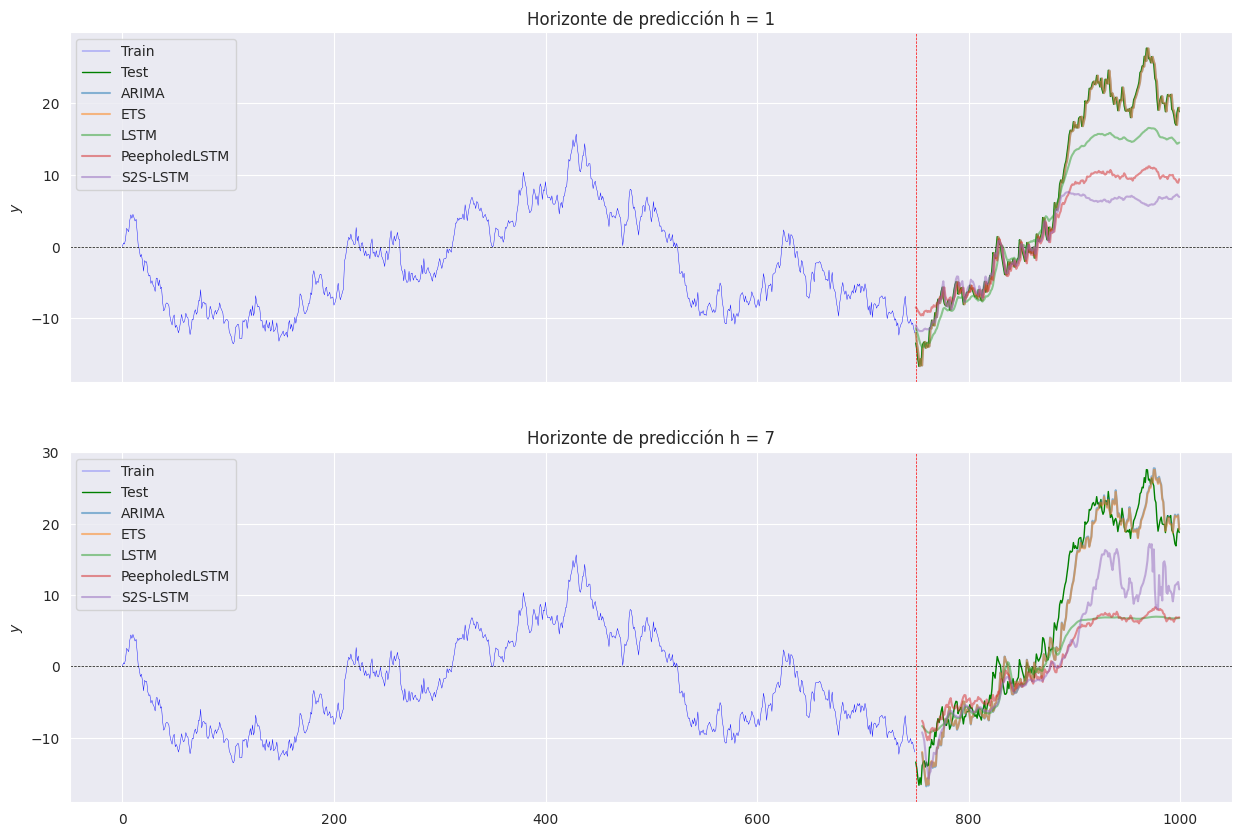

In [58]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

i=0

for h in h_list:
    axs[i].plot(vanilla_y_train, color='blue', label='Train', lw=0.3)
    axs[i].plot(range(split_index, n_steps), vanilla_y_test, color='green', label='Test', lw=1)
    axs[i].axvline(x=split_index, color='red', linestyle='--', lw=0.5)
    axs[i].axhline(y=0, color='black', linestyle='--', lw=0.5)

    axs[i].plot(range(split_index+h-1, n_steps), rw_best_models['vanilla_rw'][h]['arima'].predictions['iterative'], alpha=0.5, label='ARIMA')
    axs[i].plot(range(split_index+h-1, n_steps), rw_best_models['vanilla_rw'][h]['ets'].predictions['iterative'], alpha=0.5, label='ETS')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_vanilla.inverse_transform(rw_best_models['vanilla_rw'][h]['stacked_lstm'].predictions['iterative']), alpha=0.5, label='LSTM')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_vanilla.inverse_transform(rw_best_models['vanilla_rw'][h]['peephole_lstm'].predictions['iterative']), alpha=0.5, label='PeepholedLSTM')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_vanilla.inverse_transform(rw_best_models['vanilla_rw'][h]['s2s_lstm'].predictions['iterative']), alpha=0.5, label='S2S-LSTM')

    axs[i].set_title("Horizonte de predicción h = "+str(h))
    axs[i].set_ylabel('$y$')
    axs[i].legend(loc='best')

    i+=1

plt.show()

### Forecasting Rw con drift y trend

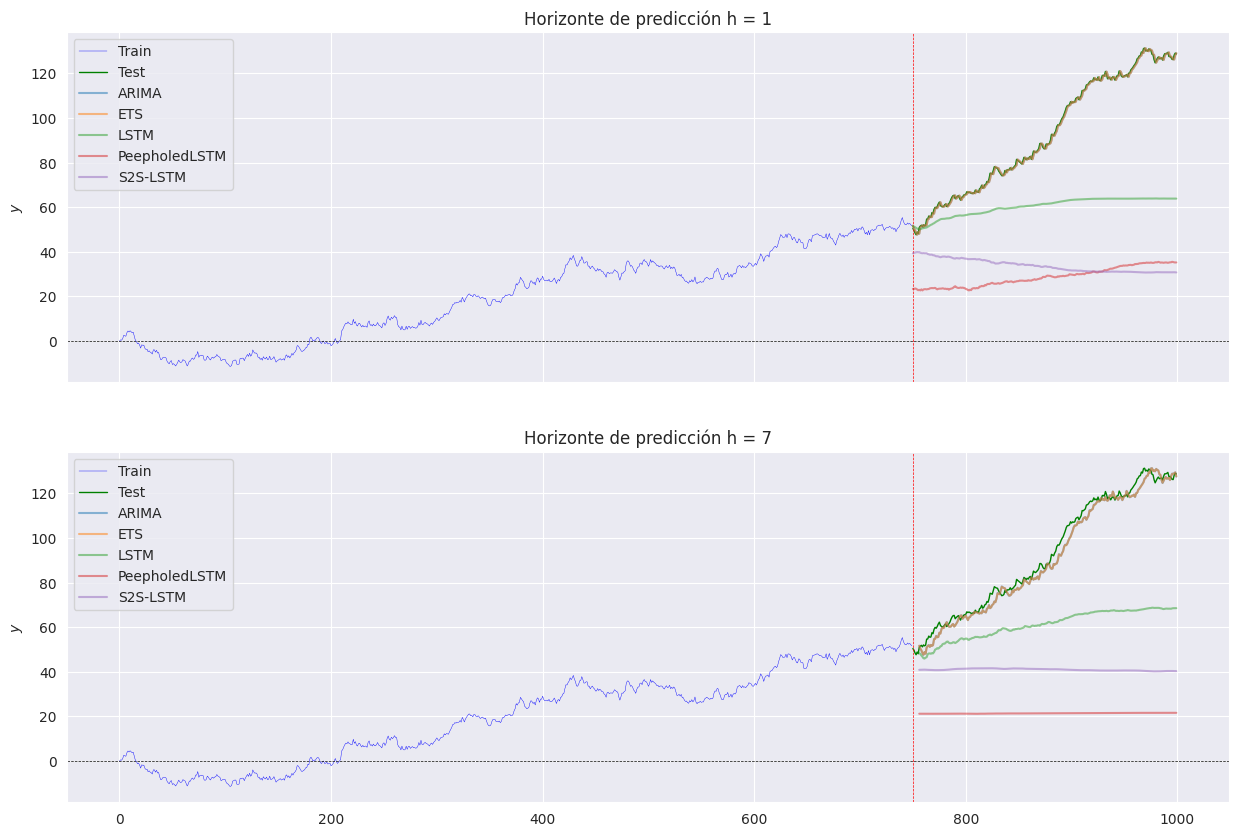

In [59]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

i=0

for h in h_list:
    axs[i].plot(drift_trend_y_train, color='blue', label='Train', lw=0.3)
    axs[i].plot(range(split_index, n_steps), drift_trend_y_test, color='green', label='Test', lw=1)
    axs[i].axvline(x=split_index, color='red', linestyle='--', lw=0.5)
    axs[i].axhline(y=0, color='black', linestyle='--', lw=0.5)

    axs[i].plot(range(split_index+h-1, n_steps), rw_best_models['drift_trend_rw'][h]['arima'].predictions['iterative'], alpha=0.5, label='ARIMA')
    axs[i].plot(range(split_index+h-1, n_steps), rw_best_models['drift_trend_rw'][h]['ets'].predictions['iterative'], alpha=0.5, label='ETS')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_drift_trend.inverse_transform(rw_best_models['drift_trend_rw'][h]['stacked_lstm'].predictions['iterative']), alpha=0.5, label='LSTM')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_drift_trend.inverse_transform(rw_best_models['drift_trend_rw'][h]['peephole_lstm'].predictions['iterative']), alpha=0.5, label='PeepholedLSTM')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_drift_trend.inverse_transform(rw_best_models['drift_trend_rw'][h]['s2s_lstm'].predictions['iterative']), alpha=0.5, label='S2S-LSTM')

    axs[i].set_title("Horizonte de predicción h = "+str(h))
    axs[i].set_ylabel('$y$')
    axs[i].legend(loc='best')

    i+=1

plt.show()

### Residuos

Se presentan adicionalmente los errores o residuos de predicción:

In [ ]:
def calculate_residuals(y_true, inner_key, model, scaler=None):
    predictions = model.predictions['iterative']
    if scaler:
        predictions = scaler.inverse_transform(predictions).reshape(-1)
    return y_true[inner_key-1:] - predictions

residuals = defaultdict(lambda: defaultdict(dict))

for outer_key, dgp in rw_best_models.items():
    y_true = vanilla_y_test if outer_key == 'vanilla_rw' else drift_trend_y_test
    scaler = scaler_vanilla if outer_key == 'vanilla_rw' else scaler_drift_trend

    for inner_key, h in dgp.items():
        for name, model in h.items():
            residuals[outer_key][inner_key][name] = calculate_residuals(
                y_true, inner_key, model, None if name in ['arima', 'ets'] else scaler
            )

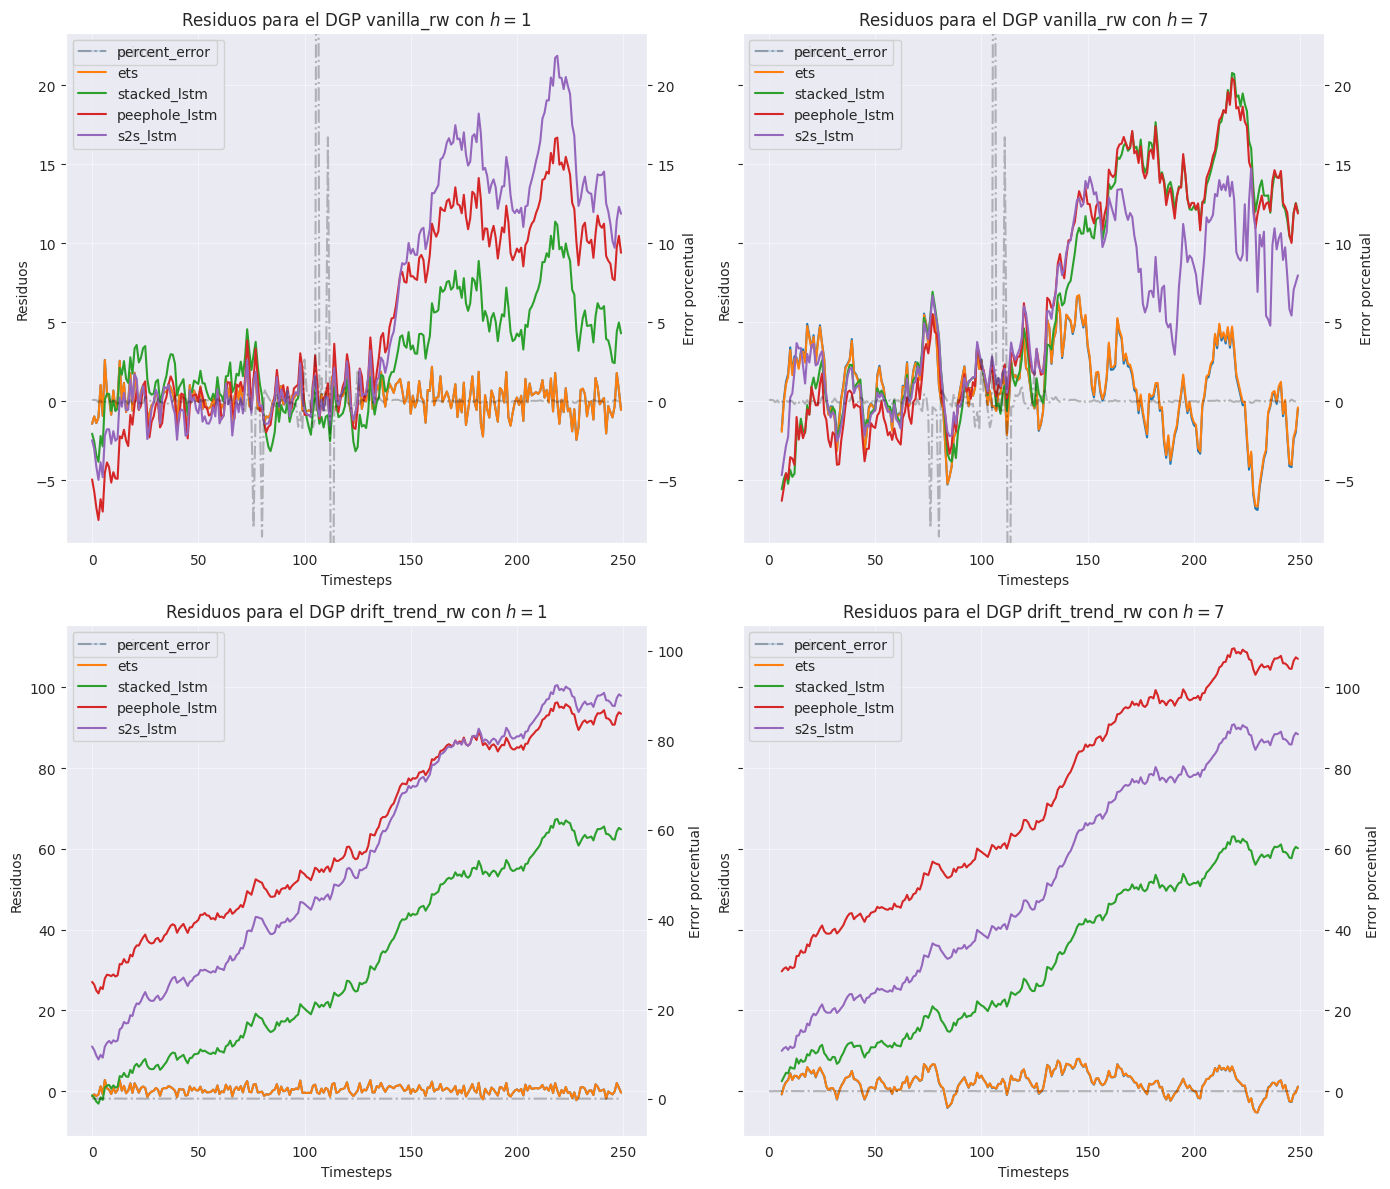

In [208]:
def plot_residuals_grid(residuals, vanilla_y_test, drift_trend_y_test):
    combinations = [(outer_key, inner_key) for outer_key, inner_dict in residuals.items() for inner_key in inner_dict.keys()]

    fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharey='row')
    axes = axes.flatten()

    for idx, (ax, (outer_key, inner_key)) in enumerate(zip(axes, combinations)):
        residuals_row = [residuals[outer_key][inner_key][name] for name in residuals[outer_key][inner_key]]

        for name, residual in residuals[outer_key][inner_key].items():
            if idx % 2 == 1:
                ax.plot(range(6, 6 + len(residual)), residual, label=f'{name}')
            else:
                ax.plot(residual, label=f'{name}')

        ax.set_xlabel('Timesteps')
        ax.set_ylabel('Residuos')
        ax.set_title(f'Residuos para el DGP {outer_key} con $h={inner_key}$')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.5)

        if outer_key == 'vanilla_rw':
            secondary_y = np.diff(vanilla_y_test) / vanilla_y_test[:-1]
        else:
            secondary_y = np.diff(drift_trend_y_test) / drift_trend_y_test[:-1]

        ax2 = ax.twinx()
        ax2.plot(secondary_y, color='black', alpha=0.25, linestyle='-.' ,label='percent_error')
        ax2.set_ylabel('Error porcentual')
        ax2.set_ylim(ax.get_ylim())
        ax2.legend(loc='upper left')
        ax2.grid(False)

    plt.tight_layout()
    plt.show()

plot_residuals_grid(residuals, vanilla_y_test, drift_trend_y_test)


### Métricas comparativas

Para cada escenario planteado y para cada horizonte de predicción se comparan todas las versiones de los modelos (más una predicción näive en donde se forecastea $y_{t+h}$ con la última observación disponible $y_t$) en su capacidad predictiva. En este análisis, no solo se comparan métricas como MSE o MAE directamente sino que se aplica el test de Diebold-Mariano para evaluar la significancia estadística de las diferencias entre los forecasts de cada modelo.

Primero se calculan las métricas de precisión del forecasting para una estrategia naive, en donde el mejor pronóstico es la última observación realizada de $y$, para cualquier horizonte de pronóstico $h$.

In [60]:
h_list = [1,7]
scenarios = ['vanilla_rw', 'drift_trend_rw']

ground_truth = list(zip([vanilla_y_train, drift_trend_y_train],
                        [vanilla_y_test, drift_trend_y_test]))

naive_forecasting = defaultdict((lambda: defaultdict(((lambda: defaultdict(dict))))))

s = 0

for i, j in ground_truth:
  for p in range(len(h_list)):
    forecast = forecast_evaluation(h=h_list[p],
                                    y_true = j,
                                    y_pred = np.r_[i[-1], j[:-h_list[p]]])

    naive_forecasting[scenarios[s]]['h_'+f'{h_list[p]}']['naive']['forecast'] = np.r_[i[-1], j[:-h_list[p]]]

  s += 1

A continuación, se le concatenan las métricas calculadas con los modelos ya entrenados:

In [113]:
def evaluate_model(h, key2, y_true, model, scaler=None):
    predictions = model.predictions['iterative']
    if scaler:
        predictions = scaler.inverse_transform(predictions)
    return forecast_evaluation(h=key2, y_true=y_true, y_pred=predictions)

def process_key(dgp, y_true, scaler=None):
    results = defaultdict(dict)
    for key2, h in dgp.items():
        results['h_' + f'{key2}']['naive'] = forecast_evaluation(
            h=key2,
            y_true=y_true,
            y_pred=naive_forecasting[key]['h_' + f'{key2}']['naive']['forecast']
        )
        for name, model in h.items():
            results['h_' + f'{key2}'][name] = evaluate_model(h, key2, y_true, model, scaler if name not in ['arima', 'ets'] else None)
    return results

comparative_results = defaultdict(lambda: defaultdict(dict))

for key, dgp in rw_best_models.items():
    if key == 'vanilla_rw':
        y_true = vanilla_y_test
        scaler = scaler_vanilla
    else:
        y_true = drift_trend_y_test
        scaler = scaler_drift_trend
    comparative_results[key] = process_key(dgp, y_true, scaler)

In [114]:
rows = []

for method, inner_dict in comparative_results.items():
    for horizon, model_dict in inner_dict.items():
        for model, metrics_dict in model_dict.items():
          for metric, value in metrics_dict.items():
              rows.append([method, horizon, model, metric, value])

df = pd.DataFrame(rows, columns=['DGP', 'horizon', 'model', 'metric', 'value'])
df = pd.pivot_table(df, index=['DGP','horizon','model'], columns='metric', values='value')

ordering_dgp = ['vanilla_rw', 'drift_trend_rw']
ordering_horizon = ['h_1', 'h_7']
ordering_model = ['naive','arima','ets','stacked_lstm','peephole_lstm','s2s_lstm']

df_reset = df.reset_index()

df_reset['DGP'] = pd.Categorical(df_reset['DGP'], categories=ordering_dgp, ordered=True)
df_reset['horizon'] = pd.Categorical(df_reset['horizon'], categories=ordering_horizon, ordered=True)
df_reset['model'] = pd.Categorical(df_reset['model'], categories=ordering_model, ordered=True)

df_sorted = df_reset.sort_values(['DGP', 'horizon','model'])
df_sorted = df_sorted.set_index(['DGP', 'horizon', 'model'])

df_sorted

metric                                     MAE       MAPE         MSE  \
DGP            horizon model                                            
vanilla_rw     h_1     naive           0.77488   51.63337     0.93825   
                       arima           0.77452   50.12094     0.94110   
                       ets             0.77437   50.32917     0.94090   
                       stacked_lstm    3.29717  731.68383    18.12172   
                       peephole_lstm   5.65867  530.74801    56.97877   
                       s2s_lstm        6.69342  451.14498    91.35784   
               h_7     naive           2.18337   78.41330     7.59645   
                       arima           2.18916   79.02410     7.64968   
                       ets             2.18642   79.10802     7.61212   
                       stacked_lstm    7.38703  447.28738    95.16528   
                       peephole_lstm   7.64031  417.00920    97.62117   
                       s2s_lstm        5.74127  588.63361    52.85914   
drift_trend_rw h_1     naive           0.80686    0.95013     1.01682   
                       arima           0.80887    0.95234     1.02175   
                       ets             0.80878    0.95222     1.02149   
                       stacked_lstm   32.55233   32.00230  1551.21277   
                       peephole_lstm  63.99227   66.29140  4576.09268   
                       s2s_lstm       58.79178   60.16756  4287.75163   
               h_7     naive           2.83793    3.23801    11.64333   
                       arima           2.82447    3.22351    11.51802   
                       ets             2.84134    3.24190    11.67566   
                       stacked_lstm   32.56959   31.98696  1432.42043   
                       peephole_lstm  72.31125   75.27762  5867.64726   
                       s2s_lstm       52.76085   52.67457  3446.21624   

metric                                    RMSE      SMAPE  
DGP            horizon model                               
vanilla_rw     h_1     naive           0.96863   22.03283  
                       arima           0.97010   22.00838  
                       ets             0.97000   22.03357  
                       stacked_lstm    4.25696   44.96460  
                       peephole_lstm   7.54843   60.33053  
                       s2s_lstm        9.55813   66.66264  
               h_7     naive           2.75617   42.51801  
                       arima           2.76581   42.53528  
                       ets             2.75901   42.78872  
                       stacked_lstm    9.75527   84.13407  
                       peephole_lstm   9.88034   91.82071  
                       s2s_lstm        7.27043   74.24879  
drift_trend_rw h_1     naive           1.00837    0.95435  
                       arima           1.01082    0.95661  
                       ets             1.01069    0.95649  
                       stacked_lstm   39.38544   38.38340  
                       peephole_lstm  67.64682  102.80887  
                       s2s_lstm       65.48093   87.47604  
               h_7     naive           3.41223    3.31152  
                       arima           3.39382    3.29600  
                       ets             3.41697    3.31565  
                       stacked_lstm   37.84733   38.58285  
                       peephole_lstm  76.60057  121.82173  
                       s2s_lstm       58.70448   73.72767

#### Diebold-Mariano Test

El test de Diebold-Mariano (1995) permite comparar la precisión de 2 pronósticos. En este caso, se compara la performance para cada DGP y para cada horizonte temporal $h$ del pronóstico näive frente a los demás modelos, tomando en cuenta el error cuadrático de cada serie de pronósticos.

Para ello el test de Diebold-Mariano construye la serie de las diferencias entre los errores cuadráticos de cada modelo, la llamada **loss differential series**, la cual se define como:

$\Delta^{A,B}_{k} = (e^{A}_{k})^2-(e^{B}_{k})^2$

El test de Diebold-Mariano es un test asintótico de tipo z-score sobre el promedio de dicha serie. En este caso, se aplica su versión unilateral cuyas hipótesis son las siguientes:

* $H_0$: la precisión del modelo A (en este caso, el pronóstico näive) es mayor o igual a la del modelo B (modelo alternativo).
* $H_1$: la precisión del modelo A es menor a la del modelo B.

In [115]:
p_value_dict = defaultdict((lambda: defaultdict(dict)))

for outer_key, dgp in rw_best_models.items():
    for inner_key, h in dgp.items():
        for name, model in h.items():
          if outer_key == 'vanilla_rw':
            p_value = dm_test(V = vanilla_y_test[inner_key-1:].reshape(-1,1),
                    P1 = rw_best_models[outer_key][inner_key][name].predictions['iterative'].reshape(-1,1),
                    P2 = naive_forecasting[outer_key][f'h_{inner_key}']['naive']['forecast'].reshape(-1,1),
                    one_sided = True)[1][0]
          else:
             p_value = dm_test(V = drift_trend_y_test[inner_key-1:].reshape(-1,1),
                      P1 = rw_best_models[outer_key][inner_key][name].predictions['iterative'].reshape(-1,1),
                      P2 = naive_forecasting[outer_key][f'h_{inner_key}']['naive']['forecast'].reshape(-1,1),
                      one_sided = True)[1][0]

          p_value_dict[outer_key][inner_key][name] = round(p_value, 4)


In [122]:
records = []

for key, nested_dict in p_value_dict.items():
    for h, models in nested_dict.items():
        for model_name, value in models.items():
            records.append((key, h, model_name, value))

df = pd.DataFrame(records, columns=['DGP', 'h', 'p_value', 'value'])

df_pivot = df.pivot_table(index=['DGP', 'h'], columns='p_value', values='value')

df_pivot

p_value            arima     ets  peephole_lstm  s2s_lstm  stacked_lstm
DGP            h                                                       
drift_trend_rw 1  0.9917  0.9889            1.0       1.0           1.0
               7  0.0000  1.0000            1.0       1.0           1.0
vanilla_rw     1  0.8606  0.8348            1.0       1.0           1.0
               7  0.9073  0.9775            1.0       1.0           1.0

### 5.2) Escenario con *regime switching*

En esta instancia se procede a remover el conjunto de test y sustituirlo por un conjunto de datos generados por el mismo DGP pero con cambios en los parámetros que lo rigen: todos los modelos habrán sido entrenados con una muestra que difiere en su dinámica de aquella que deben forecastear, poniendo a prueba su robustez ante regime-switching. Los tipos de cambio de régimen son los que siguen:

* Vanilla RW: la distribución de los errores $\epsilon_t$ pasa de una $Normal(\mu=0, \sigma=1)$ a $Normal(\mu=0.25, \sigma=2)$
* RW con drift: el drift $\alpha$ cambia de 0.01 a 0.02
* RW con drift y trend: el drift $\alpha$ cambia de 0.01 a 0.02 y la tendencia $\beta$ decrece de 0.0002 a -0.0002

In [ ]:
vanilla_rw_post_switch = cp.deepcopy(vanilla_rw)
rw_drift_trend_post_switch = cp.deepcopy(rw_drift_trend)

In [ ]:
vanilla_rw_post_switch.regime_switch(t_switch=split_index,
                                     **{'loc':0.25, 'scale':2})

rw_drift_trend_post_switch.regime_switch(t_switch=split_index,
                                   new_drift=0.02,
                                   new_trend=-0.0002)

A continuación se grafican los 3 DGP, comparando el conjunto de test original con el nuevo surgido luego del *regime-switch*.

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

sns.lineplot(x=range(split_index), y=vanilla_rw.y[:split_index], ax=axs[0], lw=0.5, color='blue', label='Train')
sns.lineplot(x=range(split_index, len(vanilla_rw.y)), y=vanilla_rw.y[split_index:], ax=axs[0], lw=0.5, color='green', label='Test sin regime-switch')
sns.lineplot(x=range(split_index, len(vanilla_rw.y)), y=vanilla_rw_post_switch.y[split_index:], ax=axs[0], lw=0.5, color='red', label='Test con regime-switch')
axs[0].set_title("Vanilla Random Walk")
axs[0].set_xlabel("Timesteps")
axs[0].set_ylabel("$y$")

sns.lineplot(x=range(split_index), y=rw_drift_trend.y[:split_index], ax=axs[1], lw=0.5, color='blue', label='Train')
sns.lineplot(x=range(split_index, len(rw_drift_trend.y)), y=rw_drift_trend.y[split_index:], ax=axs[1], lw=0.5, color='green', label='Test sin regime-switch')
sns.lineplot(x=range(split_index, len(vanilla_rw.y)), y=rw_drift_trend_post_switch.y[split_index:], ax=axs[1], lw=0.5, color='red', label='Test con regime-switch')
axs[1].set_title("Random Walk con drift y trend")
axs[1].set_xlabel("Timesteps")

plt.legend(loc='upper left')
plt.tight_layout();

La siguiente tarea es inyectar este nuevo conjunto de test en los modelos ya entrenados con el DGP anterior y forecastear utilizando la estrategia iterativa.

In [ ]:
for key, dgp in rw_best_models.items():
    for key2, h in dgp.items():
        for name, model in h.items():
            model.forecasted = False
            if key == 'vanilla_rw':
                model.test = vanilla_rw_post_switch.y[split_index:]
            elif key == 'drift_rw':
                model.test = rw_drift_post_switch.y[split_index:]
            else:
                model.test = rw_drift_trend_post_switch.y[split_index:]

Ahora, solo resta volver a realizar el forecasting

In [ ]:
for key, dgp in rw_best_models.items():
    for key2, h in dgp.items():
        for name, model in h.items():
            if name in ['arima','ets']:
                model.predict(h=key2)
            else:
                model.predict()

### Forecasting Vanilla RW con *regime-switching*

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

i=0

for h in h_list:
    axs[i].plot(vanilla_y_train, color='blue', label='Train', lw=0.3)
    axs[i].plot(range(split_index, n_steps), vanilla_rw_post_switch.y[split_index:], color='green', label='Test', lw=1)
    axs[i].axvline(x=split_index, color='red', linestyle='--', lw=0.5)
    axs[i].axhline(y=0, color='black', linestyle='--', lw=0.5)

    axs[i].plot(range(split_index+h-1, n_steps), rw_best_models['vanilla_rw'][h]['arima'].predictions['iterative'], alpha=0.5, label='ARIMA')
    axs[i].plot(range(split_index+h-1, n_steps), rw_best_models['vanilla_rw'][h]['ets'].predictions['iterative'], alpha=0.5, label='ETS')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_vanilla.inverse_transform(rw_best_models['vanilla_rw'][h]['stacked_lstm'].predictions['iterative']), alpha=0.5, label='LSTM')

    axs[i].set_title("Horizonte de predicción h = "+str(h))
    axs[i].set_ylabel('$y$')
    axs[i].legend(loc='best')

    i+=1

plt.show()

### Forecasting RW con drift luego de *regime-switch*

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

i=0

for h in h_list:
    axs[i].plot(drift_y_train, color='blue', label='Train', lw=0.3)
    axs[i].plot(range(split_index, n_steps), rw_drift_post_switch.y[split_index:], color='green', label='Test', lw=1)
    axs[i].axvline(x=split_index, color='red', linestyle='--', lw=0.5)
    axs[i].axhline(y=0, color='black', linestyle='--', lw=0.5)

    axs[i].plot(range(split_index+h-1, n_steps), rw_best_models['drift_rw'][h]['arima'].predictions['iterative'], alpha=0.5, label='ARIMA')
    axs[i].plot(range(split_index+h-1, n_steps), rw_best_models['drift_rw'][h]['ets'].predictions['iterative'], alpha=0.5, label='ETS')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_vanilla.inverse_transform(rw_best_models['drift_rw'][h]['stacked_lstm'].predictions['iterative']), alpha=0.5, label='LSTM')

    axs[i].set_title("Horizonte de predicción h = "+str(h))
    axs[i].set_ylabel('$y$')
    axs[i].legend(loc='upper left')

    i+=1

plt.show()

### Forecasting RW con drift y trend luego de *regime-switching*

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

i=0

for h in h_list:
    axs[i].plot(drift_trend_y_train, color='blue', label='Train', lw=0.3)
    axs[i].plot(range(split_index, n_steps), rw_drift_trend_post_switch.y[split_index:], color='green', label='Test', lw=1)
    axs[i].axvline(x=split_index, color='red', linestyle='--', lw=0.5)
    axs[i].axhline(y=0, color='black', linestyle='--', lw=0.5)

    axs[i].plot(range(split_index+h-1, n_steps), rw_best_models['drift_trend_rw'][h]['arima'].predictions['iterative'], alpha=0.5, label='ARIMA')
    axs[i].plot(range(split_index+h-1, n_steps), rw_best_models['drift_trend_rw'][h]['ets'].predictions['iterative'], alpha=0.5, label='ETS')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_vanilla.inverse_transform(rw_best_models['drift_trend_rw'][h]['stacked_lstm'].predictions['iterative']), alpha=0.5, label='LSTM')

    axs[i].set_title("Horizonte de predicción h = "+str(h))
    axs[i].set_ylabel('$y$')
    axs[i].legend(loc='best')

    i+=1

plt.show()

## 6) Comparación entre modelos

Para cada escenario planteado y para cada horizonte de predicción se comparan todas las versiones de los modelos (más una predicción näive en donde se forecastea $y_{t+h}$ con la última observación disponible $y_t$) en su capacidad predictiva. En este análisis, no solo se comparan métricas como MSE o MAE directamente sino que se aplican test de Diebold-Mariano para evaluar la significancia estadística de las diferencias entre los forecasts de cada modelo.

Primero se calculan las métricas de precisión del forecasting para una estrategia naive, en donde el mejor pronóstico es la última observación realizada de $y$, para cualquier horizonte de pronóstico $h$.

In [ ]:
h_list = [1,7,14]
scenarios = ['vanilla_rw', 'drift_rw', 'drift_trend_rw']

ground_truth = list(zip([vanilla_y_train, drift_y_train, drift_trend_y_train],
                        [vanilla_rw_post_switch, rw_drift_post_switch, rw_drift_trend_post_switch]))

naive_forecasting = defaultdict((lambda: defaultdict(dict)))

s = 0

for i, j in ground_truth:
    for p in range(len(h_list)):
        forecast = forecast_evaluation(h=h_list[p],
                                        y_true = j.y[split_index:],
                                        y_pred = np.r_[i[-1], j.y[split_index:-h_list[p]]])
        naive_forecasting[scenarios[s]]['h_'+f'{h_list[p]}']['naive'] = forecast

    s += 1

A continuación, se le concatenan las métricas calculadas con los modelos ya entrenados:

In [ ]:
comparative_results = defaultdict((lambda: defaultdict(dict)))

for key, dgp in rw_best_models.items():
    for key2, h in dgp.items():
        comparative_results[key]['h_'+f'{key2}']['naive'] = list(naive_forecasting[key]['h_'+f'{key2}'].values())[0]
        for name, model in h.items():
            if name in ['arima','ets']:
                model.evaluate_forecast(h=key2)
            elif name == 'stacked_lstm':
                model.evaluate_forecast()
            comparative_results[key]['h_'+f'{key2}'][name] = model.evaluation_results['iterative']

In [ ]:
rows = []

for method, inner_dict in comparative_results.items():
    for horizon, model_dict in inner_dict.items():
        for model, metrics_dict in model_dict.items():
            for metric, value in metrics_dict.items():
                rows.append([method, horizon, model, metric, value])

df = pd.DataFrame(rows, columns=['DGP', 'horizon', 'model', 'metric', 'value'])
df = pd.pivot_table(df, index=['DGP','horizon','model'], columns='metric', values='value')

# ustom ordering
ordering_dgp = ['vanilla_rw', 'drift_rw', 'drift_trend_rw']
ordering_horizon = ['h_1', 'h_7', 'h_14']
ordering_model = ['naive','arima','ets','stacked_lstm']

df_reset = df.reset_index()

df_reset['DGP'] = pd.Categorical(df_reset['DGP'], categories=ordering_dgp, ordered=True)
df_reset['horizon'] = pd.Categorical(df_reset['horizon'], categories=ordering_horizon, ordered=True)
df_reset['model'] = pd.Categorical(df_reset['model'], categories=ordering_model, ordered=True)

df_sorted = df_reset.sort_values(['DGP', 'horizon','model'])
df_final = df_sorted.set_index(['DGP', 'horizon', 'model'])

df_final


In [ ]:
dm_test(V = y,
        P1 = rw_best_models['vanilla_rw'][1]['arima'].predictions['iterative'],
        P2 = rw_best_models['vanilla_rw'][1]['stacked_lstm'].predictions['iterative'],
        one_sided = True)

In [ ]:
rw_best_models